In [1]:
from MieSppForce import  green_func, frenel, dipoles, force
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad

In [2]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

def get_directivity(wl, P,M, eps_Au):
    px,py,pz = P
    mx, my,mz = M
    ka = -1j*np.sqrt(1/(eps_Au(wl)+1))
    kspp = np.sqrt(eps_Au(wl)/(eps_Au(wl)+1))
    I = lambda phi:  np.abs((mx/c_const+1j*ka*py)*np.sin(phi) + (my/c_const - 1j*ka*px)*np.cos(phi) - kspp*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return  lambda phi: 2 * np.pi * I(phi) / Imax
    

In [ ]:
#eps_Au = frenel.get_interpolate('Au')
#eps_Si = frenel.get_interpolate('Si')
eps_Ag = frenel.get_interpolate('Ag')

eps_Si = 3 
R = 297/2
dist = 0
a_angle = 0
phase = 0

point = [0,0,dist+R]

In [13]:

STOP=45

wls=np.linspace(800,1100,60)
angles = np.linspace(1*np.pi/180, 70*np.pi/180, 60)

F_x = np.empty((len(wls),len(angles), 8))
F_y = np.empty_like(F_x)
F_z = np.empty_like(F_x)

P,M = np.empty((len(wls),len(angles),3), dtype=complex),np.empty((len(wls),len(angles),3), dtype=complex)



for i in tqdm(range(len(wls))):
    for j in range(len(angles)):
        f =  force.F(wls[i], eps_Au, point, R, eps_Si, angles[j],amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
        F_x[i,j,:] = f[0]
        F_y[i,j,:] = f[1]
        F_z[i,j,:] = f[2]
        p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angles[j], amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)

        p,m = p[:,0],m[:,0]
        P[i,j,:],M[i,j,:]=p,m


100%|██████████| 60/60 [02:37<00:00,  2.62s/it]


In [14]:
directivity = np.empty((len(wls),len(angles),4))

for i in tqdm(range(len(wls))):
    for j in range(len(angles)):
        D = get_directivity(wls[i], P[i,j,:], M[i,j,:], eps_Au)
        directivity[i, j, 0] = D(0)
        directivity[i, j, 1] = D(np.pi)
        directivity[i, j, 2] = D(np.pi/2)
        directivity[i, j, 3] = D(3*np.pi/2)

100%|██████████| 60/60 [00:00<00:00, 63.88it/s]


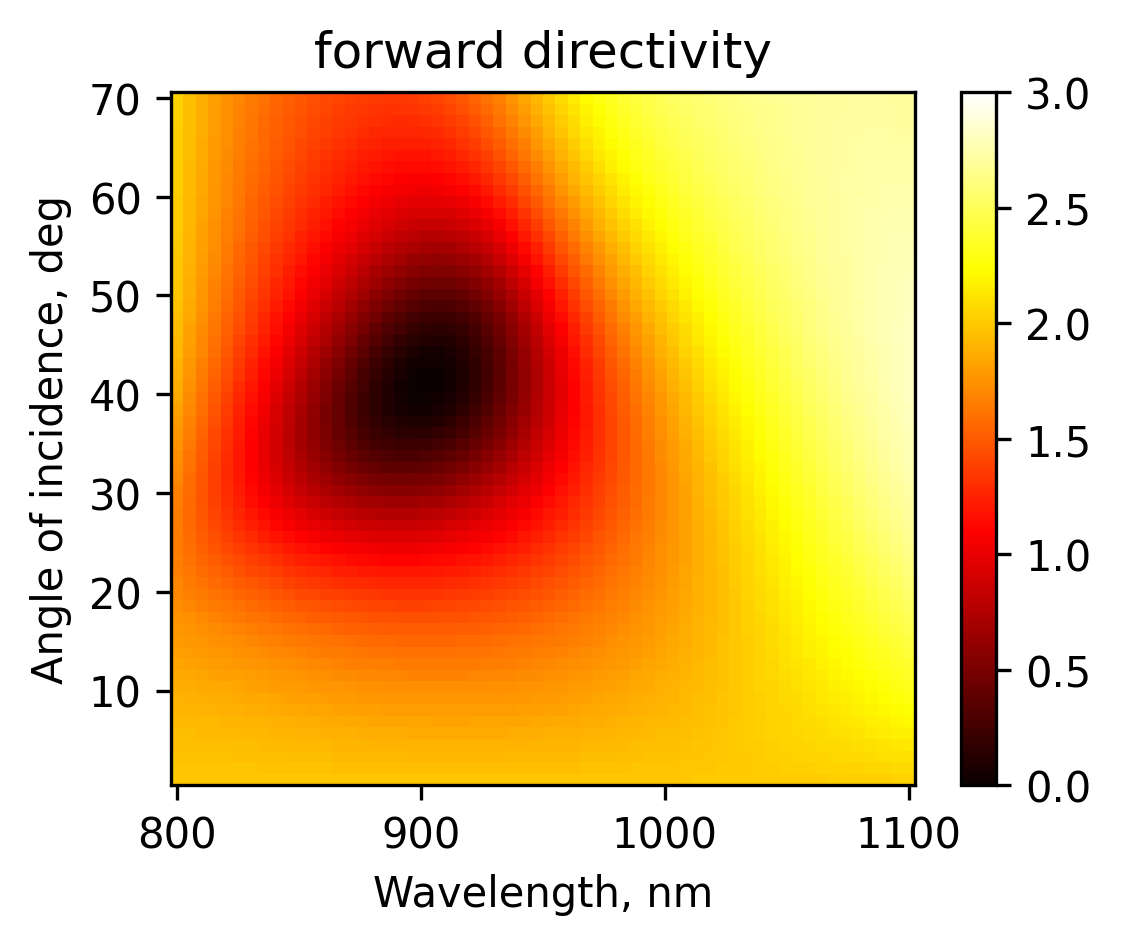

In [15]:

WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, directivity[:,:,0], cmap='hot', vmin=0, vmax=3)
plt.colorbar(contour)
plt.title('forward directivity')
plt.ylabel('Angle of incidence, deg')
plt.xlabel('Wavelength, nm')

plt.show()

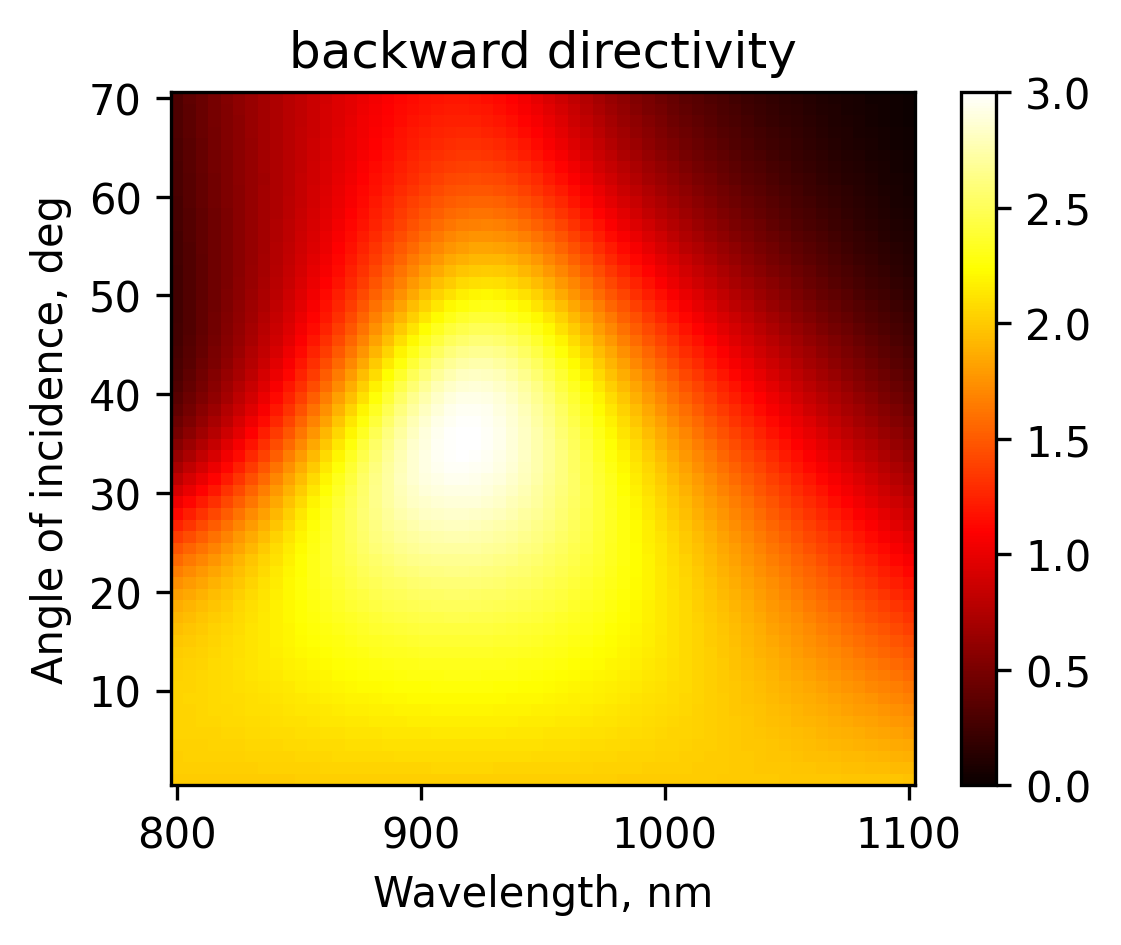

In [16]:
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, directivity[:,:,1], cmap='hot', vmin=0, vmax=3)
plt.colorbar(contour)
plt.title('backward directivity')
plt.ylabel('Angle of incidence, deg')
plt.xlabel('Wavelength, nm')

plt.show()

In [74]:
fmax_wls = 0
for i in range(len(wls)):
    f0 = force.F(wls[i], 1, [0,0,0], R, eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_wls:
        fmax_wls = f0

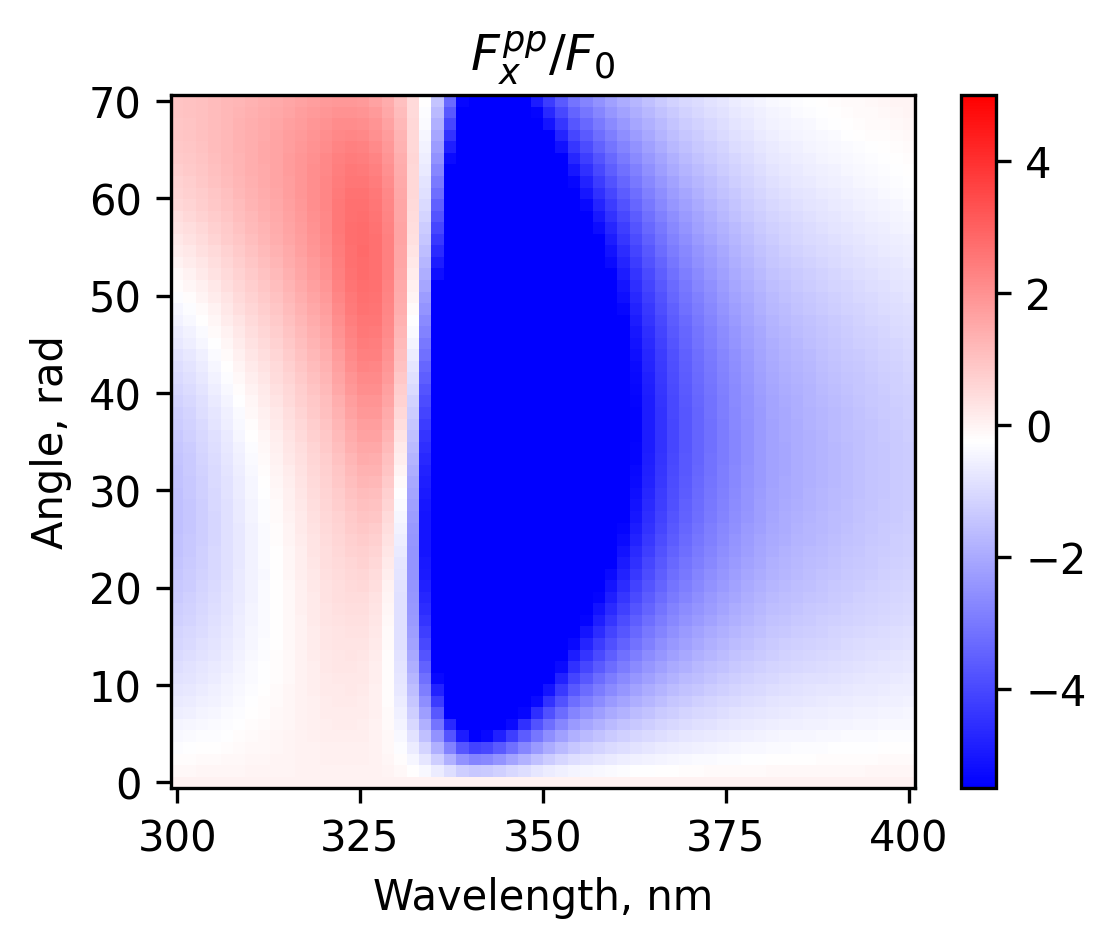

In [80]:
F_x_e0 = F_x[:, :, 1]
F_x_m0 = F_x[:, :, 4]
F_x_pp = F_x[:, :, 2]  
F_x_mm = F_x[:, :, 5]  
F_x_pm = F_x[:, :, 3]  
F_x_mp = F_x[:, :, 6]  
F_x_times = F_x[:, :, 7]

# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, (F_x[:,:,4]+F_x[:,:,0]+F_x[:,:,2])/fmax_wls, cmap='bwr', vmax=-5, vmin=5)
#contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, (F_x_pm+F_x_mp+F_x_times)/fmax_wls, cmap='bwr', vmax=0.01, vmin=-0.01)
#contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, (F_x_e0)/fmax_wls, cmap='bwr')
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$F_x^{pp}/F_0$')

plt.show()

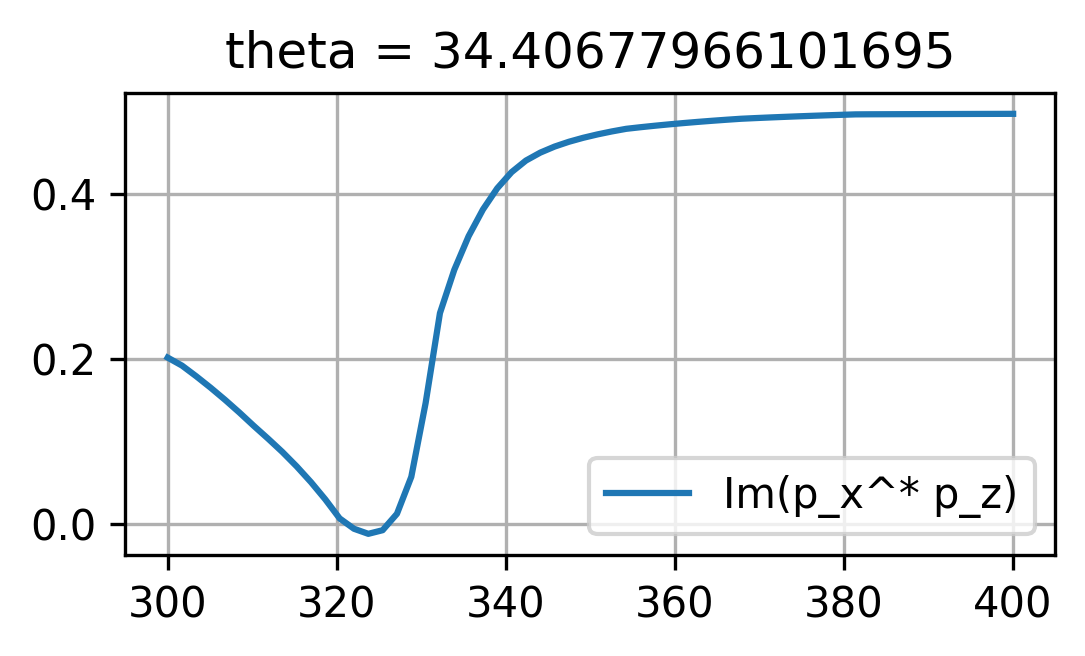

In [108]:
ind = 29
plt.figure(figsize=(4,2), dpi=300)
plt.title(f'theta = {angles[ind]*180/np.pi}')
plt.plot(wls, np.angle(P[:,ind,0].conj()*P[:,ind,2])/np.pi, label='Im(p_x^* p_z)')
plt.grid()
plt.legend()

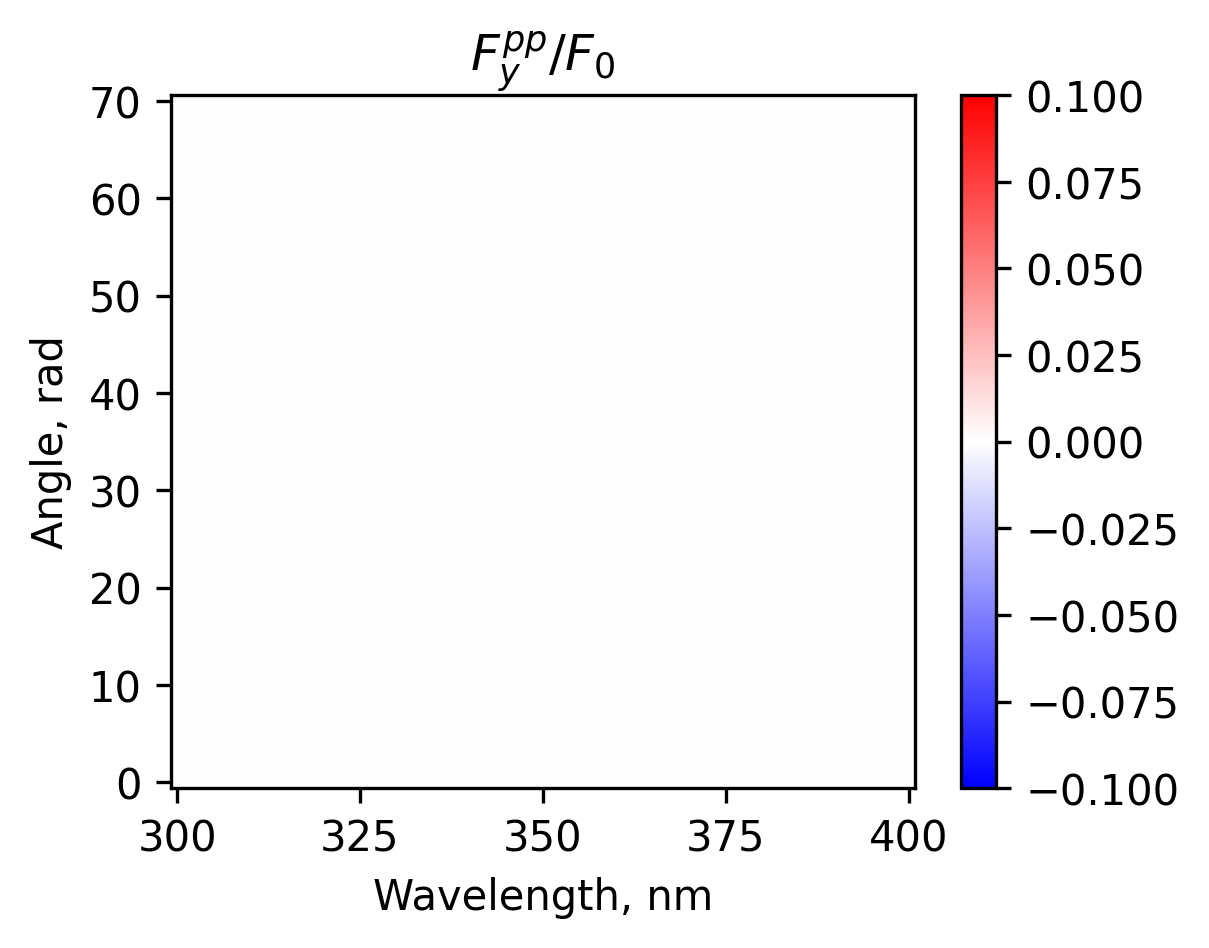

In [10]:
F_y_pp = F_y[:, :, 2]  
F_y_mm = F_y[:, :, 5]  
F_y_pm = F_y[:, :, 3]  
F_y_mp = F_y[:, :, 6]  
F_y_times = F_y[:, :, 7]

# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, (F_y_times)/fmax_wls, cmap='bwr')
#contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, (F_x_pm+F_x_mp+F_x_times)/fmax_wls, cmap='bwr', vmax=0.01, vmin=-0.01)
#contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, (F_x_e0)/fmax_wls, cmap='bwr')
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$F_y^{pp}/F_0$')

plt.show()

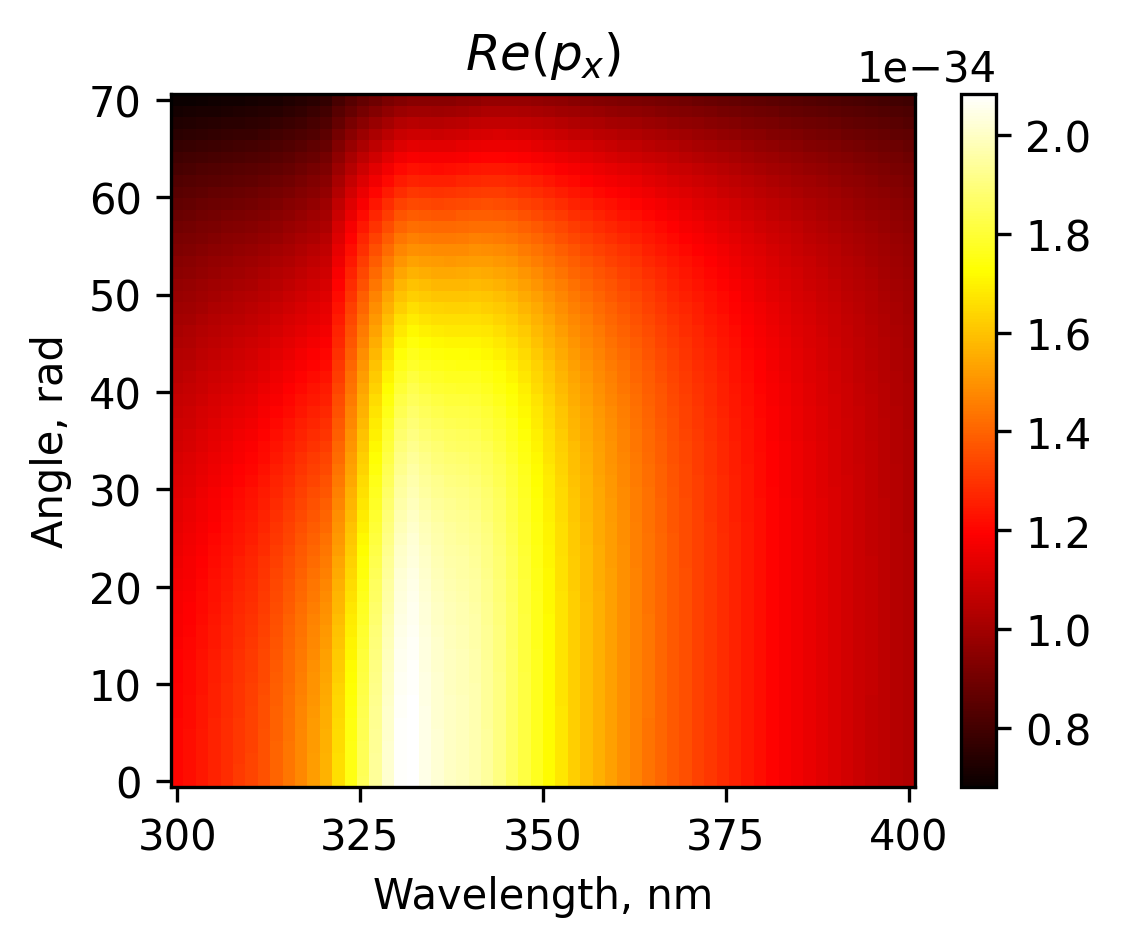

In [95]:
# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, P[:,:,0].real, cmap='hot')
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$Re(p_x)$')

plt.show()

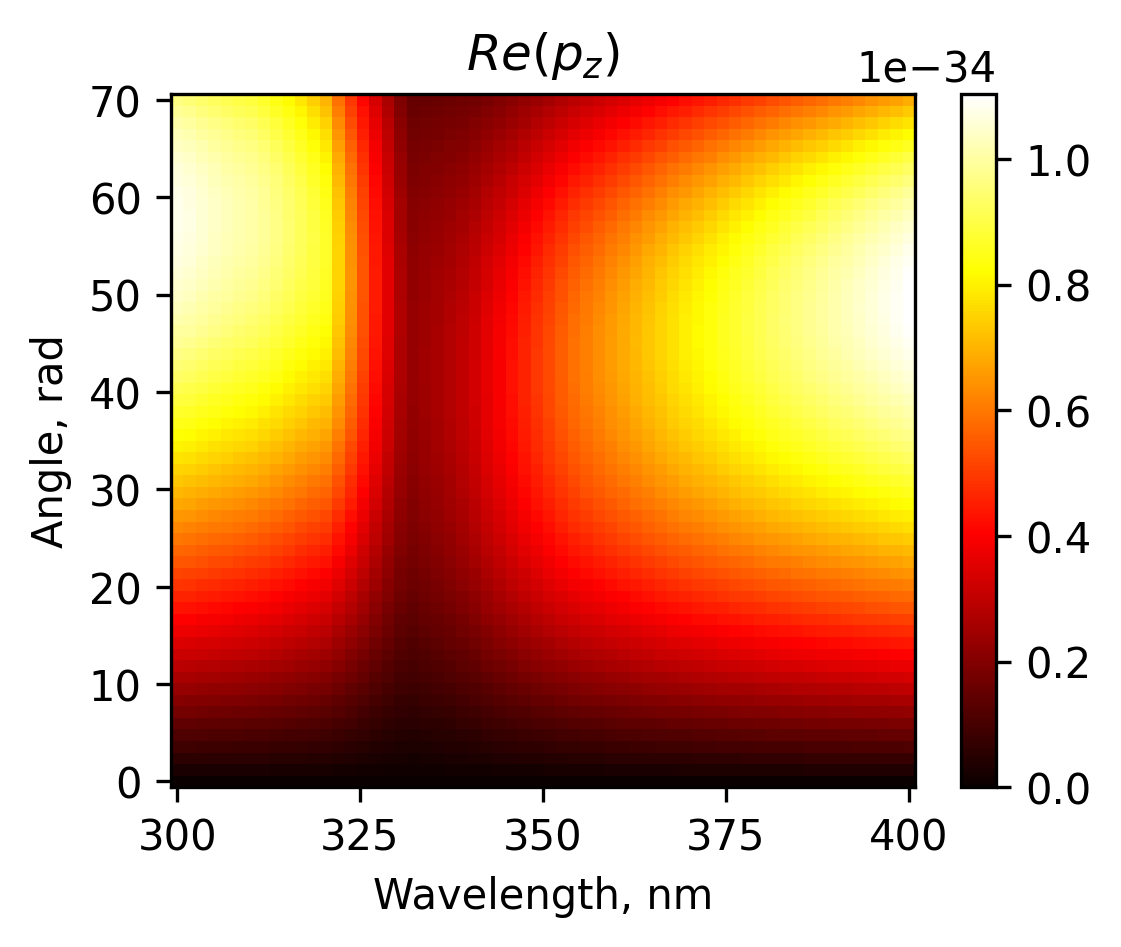

In [ ]:
# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, P[:,:,2].real, cmap='hot')
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$Re(p_z)$')

plt.show()

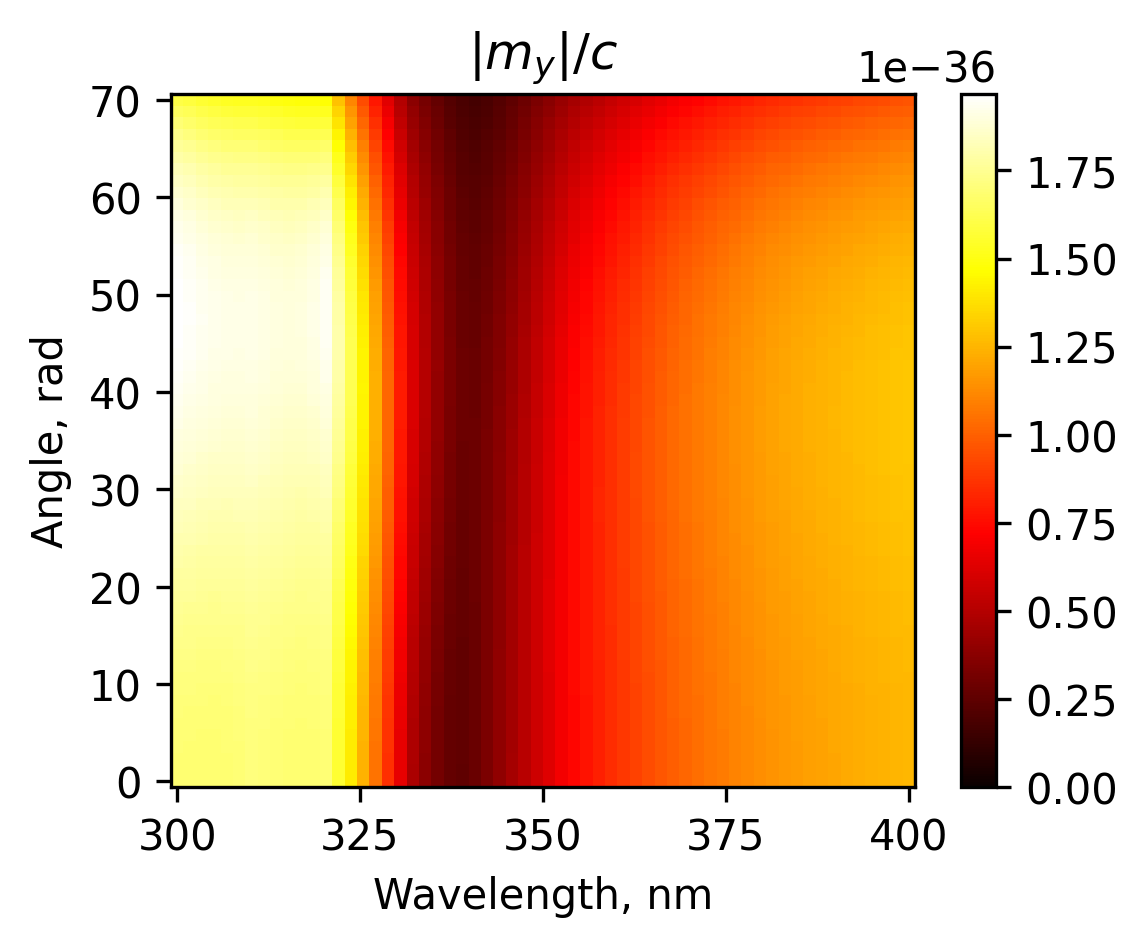

In [26]:
# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, np.abs(M[:,:,1])/c_const, cmap='hot', vmin=0)
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$|m_y|/c$')

plt.show()

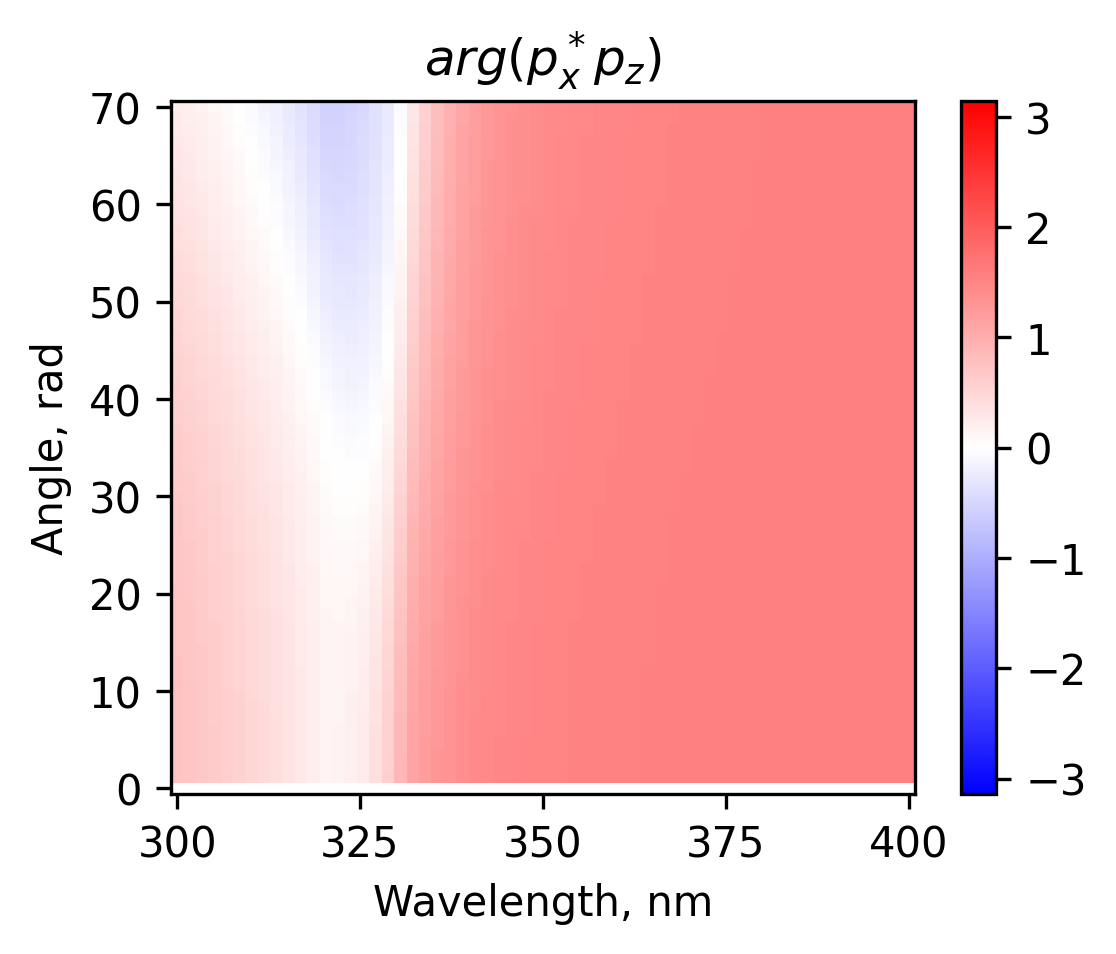

In [91]:
# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, np.angle(P[:,:,0].conj() * P[:,:,2]), cmap='bwr', vmin=-np.pi, vmax=np.pi)
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$arg(p_x^* p_z)$')

plt.show()

Text(0.5, 1.0, '$cos(arg(p_z^* m_y))$')

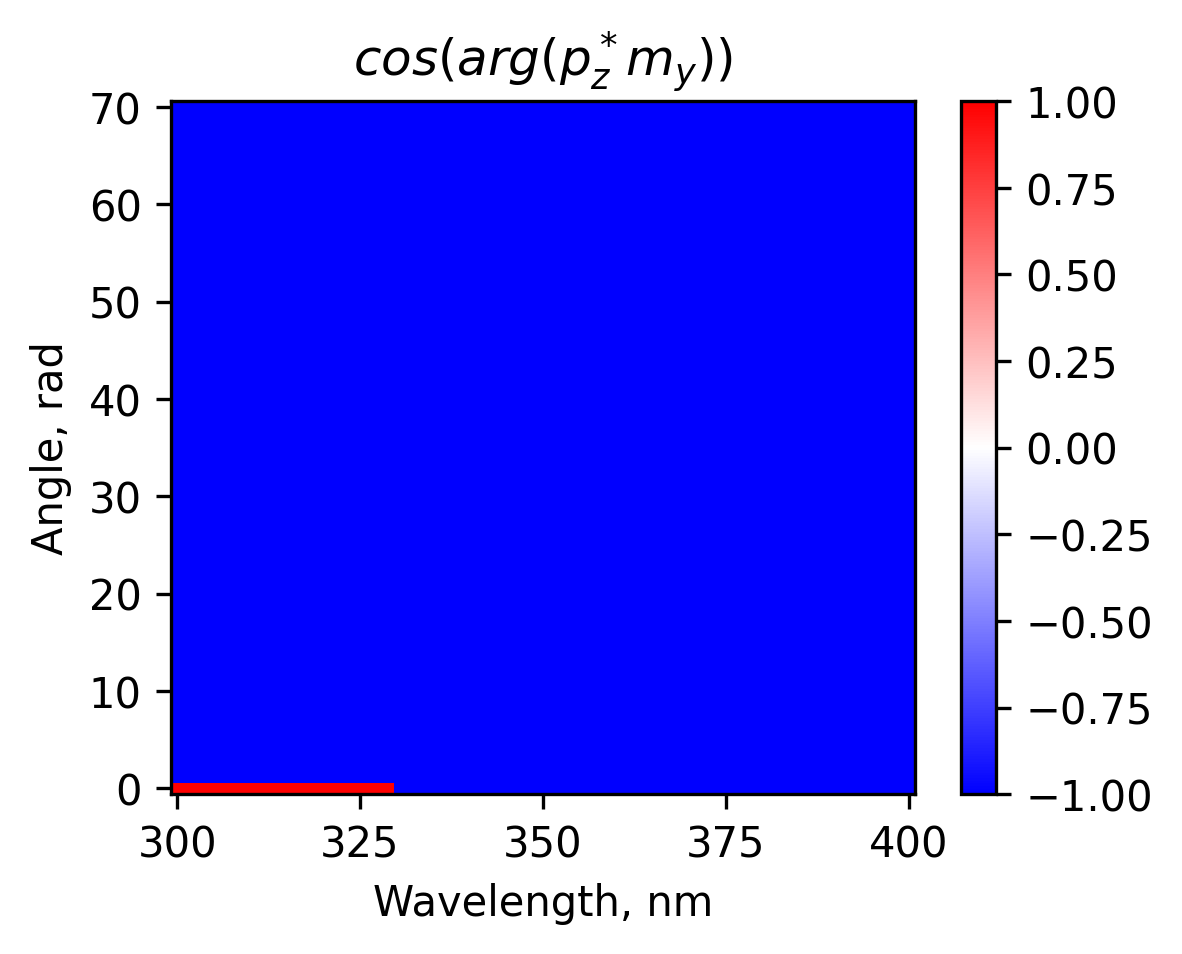

In [90]:
# Create a meshgrid for plotting
WLS, ANGLES = np.meshgrid(wls, angles, indexing='ij')  

# Plotting the heatmap
plt.figure(figsize=(4, 3), dpi=300)
contour = plt.pcolormesh(WLS, ANGLES*180/np.pi, np.cos(np.angle(P[:,:,2].conj() * M[:,:,1])), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(contour)
plt.ylabel('Angle, rad')
plt.xlabel('Wavelength, nm')
plt.title(r'$cos(arg(p_z^* m_y))$')

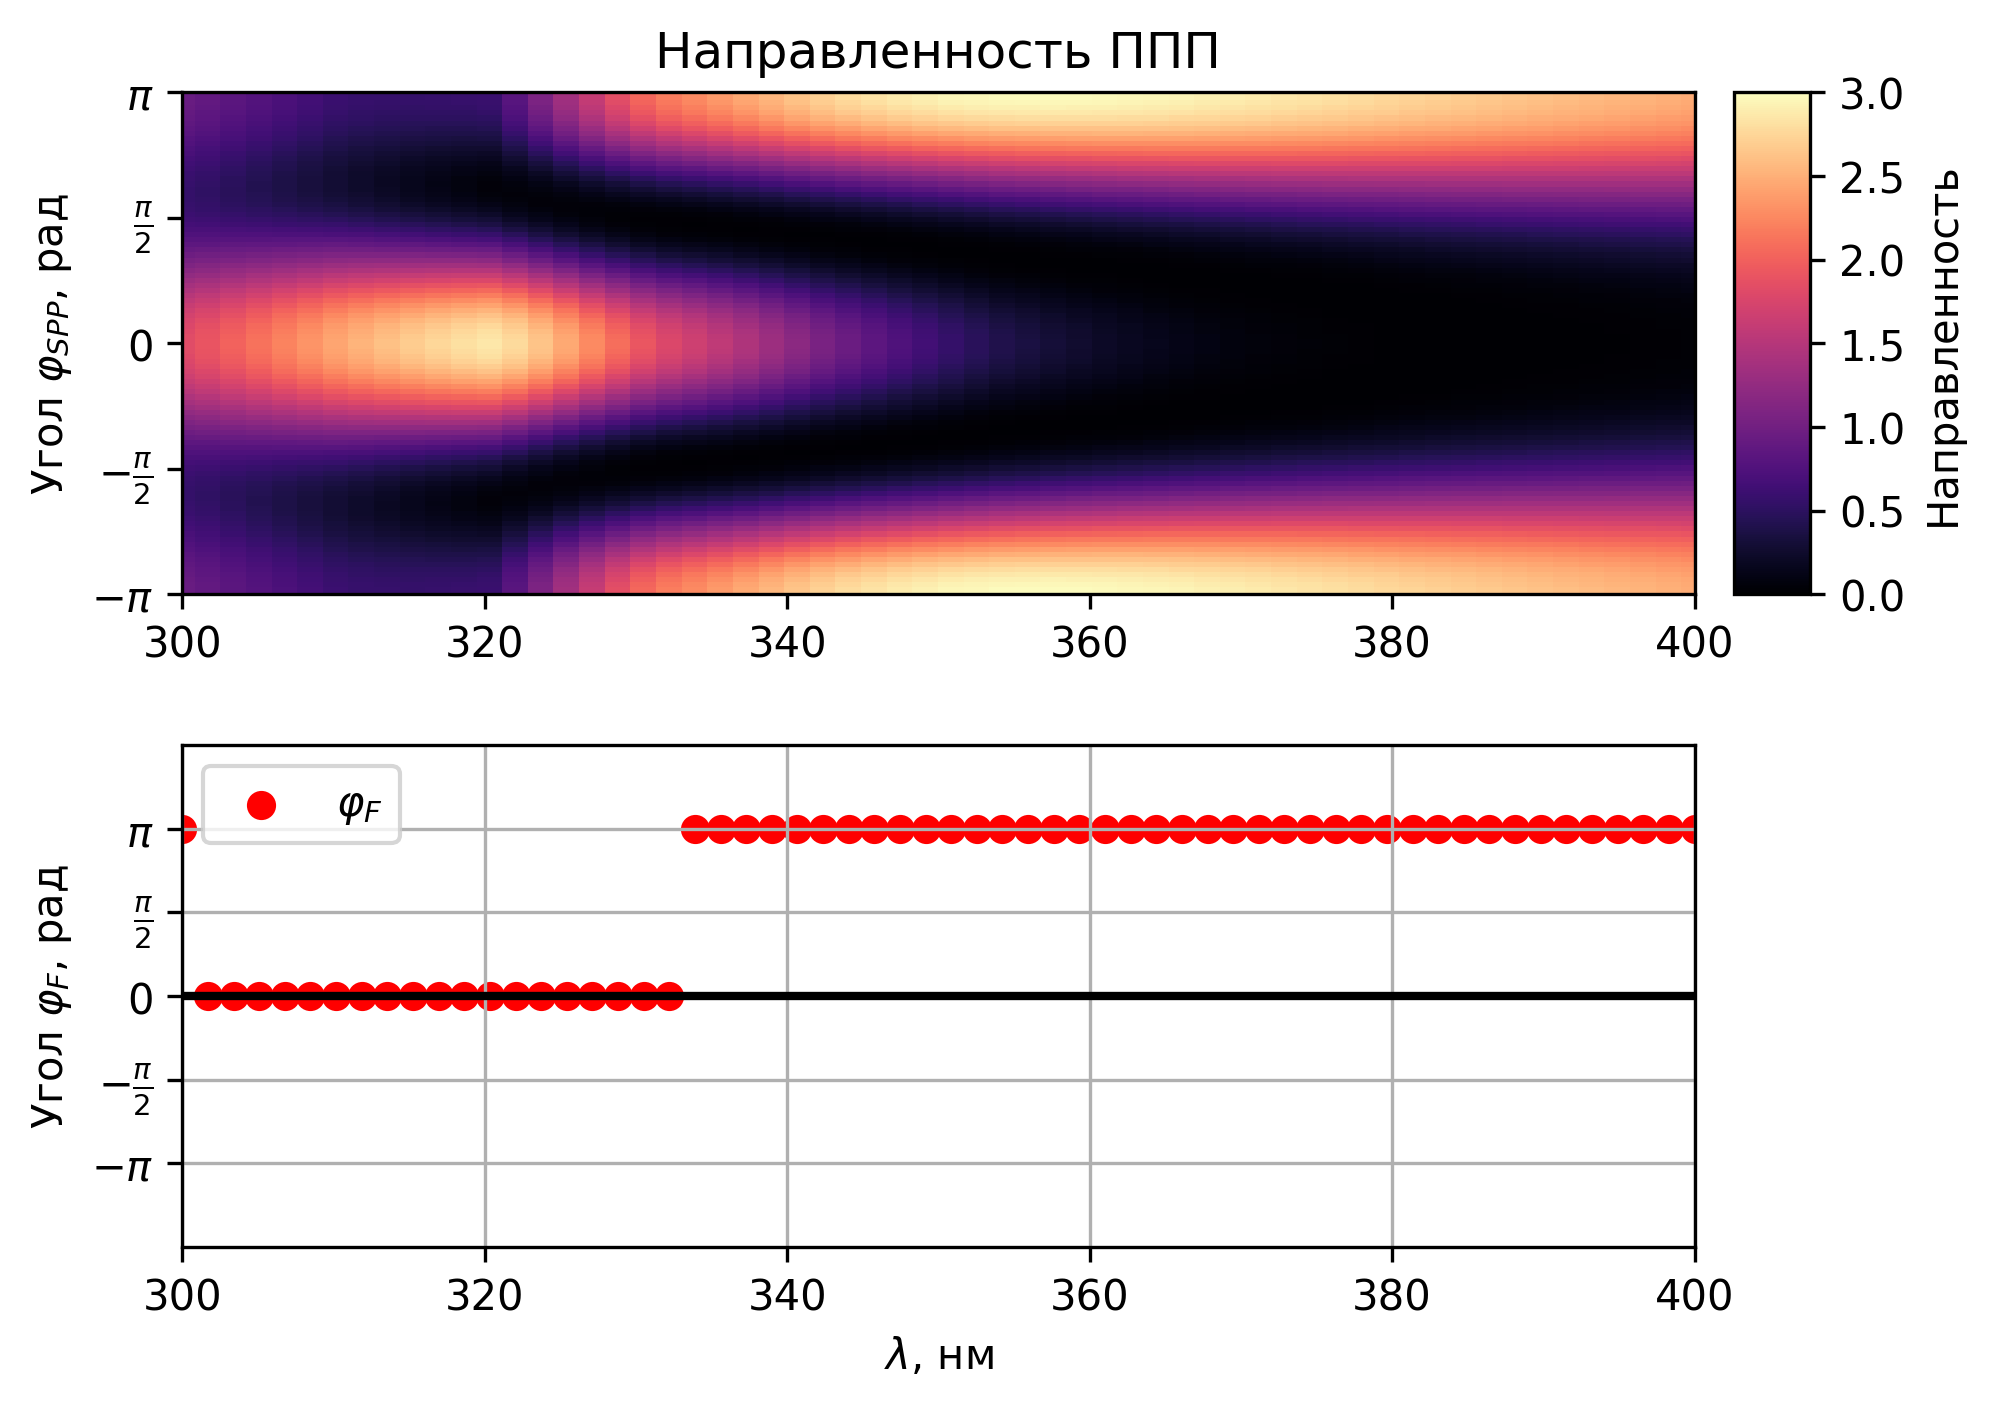

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

PHI = np.linspace(-np.pi, np.pi, 100)

ind = 29

directivityY = np.empty((len(PHI), len(wls)))
for wl_idx, wl in enumerate(wls):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P[wl_idx,ind,:], M[wl_idx,ind,:], eps_Ag)
        directivityY[angle_idx, wl_idx] = D(PHI[angle_idx])



# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(wls, PHI, directivityY, cmap='magma', vmax=3, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
# y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
# y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(-np.pi, np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc= np.arctan2(F_y[:,ind,0], F_x[:,ind,0])

#angles_no_sc= np.unwrap(angles_no_sc)

# Отрисовка угла


# Границы и метки оси Y
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(wls, angles_no_sc, label=r'$\varphi_F$', color='r', linewidth=1)
ax_bottom.set_ylim(-9*np.pi/6, 9*np.pi/6)
ax_bottom.set_xlim(wls[0], wls[-1])
ax_bottom.set_xlabel('$\\lambda$, нм')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
#plt.savefig(f'spp_vs_f_nosc_from_wl_z0_{point[2]}_R_{R}_phase_{phase}.png', dpi=300)

